# **Spark Executor 메모리 구조**

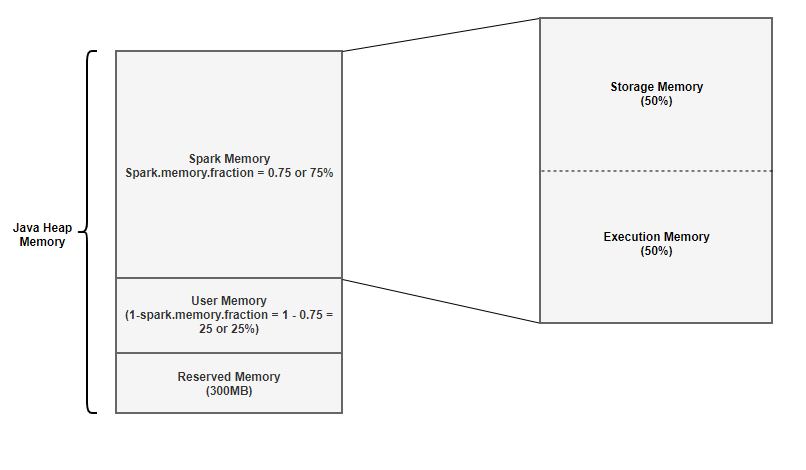

**Reserved Memory**

* 시스템에 의해 관리되는 메모리 영역으로 크기가 300MB로 고정되어 있다.
* Spark의 internal object들이 저장된다.
* Executor에 할당해준 메모리가 Reserved Memory 크기의 1.5배 미만이면 "please use larger heap size"라는 문구와 함께 에러가 발생한다.
* 메모리 사이즈 : 300 MB (고정)

**User Memory**

* 사용자가 정의한 데이터구조, UDF가 저장되는 공간이다.
* Spark에 의해 관리되지 않으며 Spark은 User Memory 공간을 인지하지 않는다.
* Java Heap 메모리에서 Reserved Memory를 제외한 공간 중에서 Spark Memory 가 아닌 나머지 부분이다.
* 메모리 사이즈 : (Java Heap Memory - Reserved Memory) * (1 - spark.memory.fraction)

**Spark Memory**

* Spark에 의해 관리되는 메모리 영역이다.
* join과 같은 연산들이 실행되는 동안의 내부 상태가 저장되거나 broadcast 변수 등이 저장되는 영역이다.
* cache/persist에 의해 캐싱된 데이터가 저장되는 영역이다.
* Storage Memory 영역과 Execution Memory의 두 영역으로 나뉜다.
* 메모리 사이즈 : (Java Heap Memory - Reserved Memory) * spark.memory.fraction

**Storage Memory**

* cache된 데이터, broadcast 변수가 저장된다.
* persist 옵션이 MEMORY이면 이 영역에 데이터가 캐싱된다.
* 캐싱할 공간이 부족하여 오래된 캐시 데이터를 지울 경우엔 LRU(Least Recently Used) 방식으로 제거한다. (즉, 블록이 디스크로 강제 추방될 수 있다.)
* 캐싱된 데이터가 메모리에서 벗어날 경우에는 디스크에 저장되거나 새로 계산되어야 한다.
* 메모리 사이즈 : (Java Heap Memory - Reserved Memory) * spark.memory.fraction * spark.memory.storageFraction

**Execution Memory**

* Spark이 task를 실행(execute)하는 동안 생성되는 object 들이 저장된다.
예시) Hash aggregation step에서 해쉬 테이블을 저장하거나, Map 수행 시 Shuffle intermediate buffer를 저장한다.
* 메모리가 충분하지 않을 경우, 디스크로의 spilling을 지원한다.
* 이 영역의 블록은 다른 task에 의해 강제로 추방될 수는 없다. (Storage Memory와 다른 점)
* 메모리 사이즈 : (Java Heap Memory - Reserved Memory) * spark.memory.fraction * (1 - spark.memory.storageFraction)

**Storage Memory vs Execution Memory 비교**

* Storage Memory는 Execution Memory가 사용되지 않는 경우에만 Execution Memory 영역을 빌릴 수 있다.
* Execution Memory 역시 Storage Memory가 사용되지 않을 경우 Storage Memory 영역을 빌릴 수 있다.
* Storage Memory가 점유한 Execution Memory 블록은 Execution이 요청할 경우, 강제로 추방될 수 있다.
* Execution Memory가 점유한 Storage Memory 블록은 Storage가 요청하더라도, 강제로 추방될 수 없다. (Spark이 Execution의 블록을 release할 때까지 기다려야 한다.)
* 블록 추방 우선도는 Storage Memory < Execution Memory라 할 수 있다.